In [142]:
import numpy as np
import matplotlib.pyplot as plt

[    0.  2000.  4000.  6000.  8000. 10000. 12000. 14000. 16000. 18000.
 20000. 22000. 24000. 26000. 28000. 30000. 32000. 34000. 36000. 38000.
 40000. 42000. 44000. 46000. 48000. 50000. 52000. 54000. 56000. 58000.
 60000. 62000. 64000. 66000. 68000. 70000. 72000. 74000. 76000. 78000.
 80000. 82000. 84000. 86000. 88000. 90000. 92000. 94000. 96000. 98000.]
Converged in 120 iterations.

--- Layer-by-Layer ---
Layer | Height (km) |  rho (kg/m³) |   T_in_vis |    T_in_IR |   T_out_IR |          E |    T (K)
-------------------------------------------------------------------------------------
    0 |       0.00 |       1.2272 |      75.45 |      19.55 |       0.00 |     549.07 |   313.70
    1 |       2.00 |       0.9676 |      99.55 |      33.95 |      32.66 |     513.86 |   308.54
    2 |       4.00 |       0.7630 |     117.04 |      49.68 |      54.05 |     471.34 |   301.95
    3 |       6.00 |       0.6016 |     136.33 |      63.56 |      77.12 |     405.26 |   290.76
    4 |       8.00 

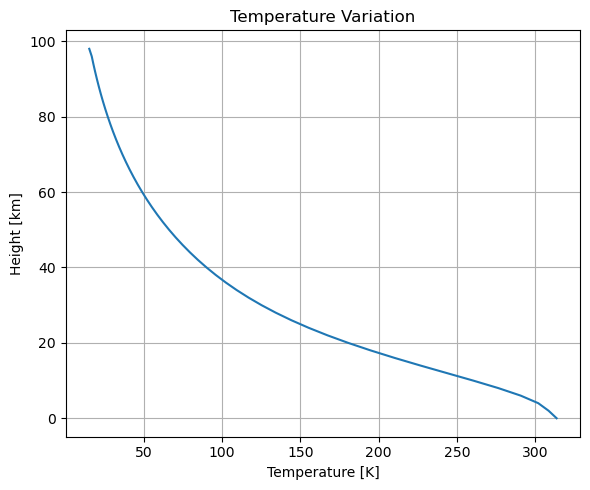

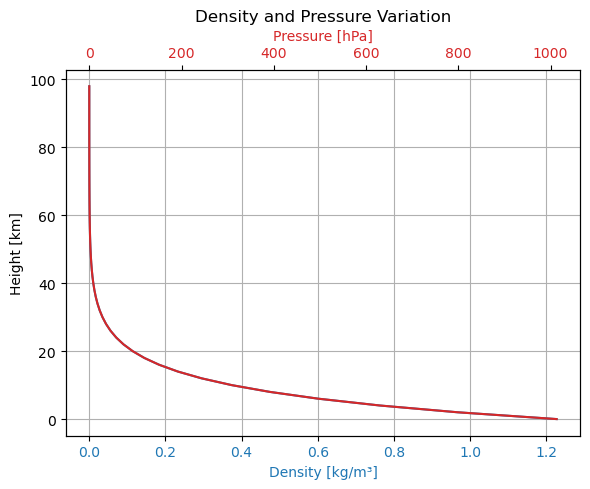

In [ ]:
N = 50             
height = 100000.0      
h = height / N        

# Constants
p0 = 101325.0               # pressure (Pa)
T0 = 288.0                  # temperature (K)
g0 = 9.81                   # (m/s^2)
M = 0.029                   # Molar mass air (kg/mol)
R = 8.314                   # (J/(mol·K))
rho0 = p0 / ((R/M) * T0) 
altitude = np.array([i * h for i in range(N)])
print(altitude)
density = rho0 * np.exp(- (g0 * M * altitude) / (R * T0))

############
sigma_SB = 5.67e-8  
F_sun = 344         
albedo = 0.3        
F_in = F_sun * (1 - albedo)

# cross sections
sigma_vis = 1e-4    # m^2/kg
sigma_IR = 1.1e-3     

# surface reflection
surface_reflectance = 0.05

####################
T_in_vis = np.zeros(N)
T_in_IR = np.zeros(N)
T_out_IR = np.zeros(N)
E = np.zeros(N)

def iterate_radiation(max_iter=1000, tol=1e-2):
    for iteration in range(max_iter):
        E_old = E.copy()

        T_in_vis.fill(0.0)
        T_in_vis[-1] = F_in 

        # top to bottom
        for i in reversed(range(N - 1)):
            T_in_vis[i] = T_in_vis[i+1] * np.exp(-sigma_vis * density[i] * h)

        # surface reflection 
        reflected_vis = T_in_vis[0] * surface_reflectance
        T_in_vis[1] += reflected_vis * np.exp(-sigma_vis * density[1] * h)

        # top to bottom
        for i in reversed(range(N - 1)):
            T_in_IR[i] = (T_in_IR[i+1] + 0.5 * E[i+1]) * np.exp(-sigma_IR * density[i] * h)

        # bottom to top
        for i in range(1, N):
            T_out_IR[i] = (T_out_IR[i-1] + 0.5 * E[i-1]) * np.exp(-sigma_IR * density[i] * h)

        # emission
        for i in range(N):
            E_plus = E[i+1] if i < N-1 else E[i]
            E_minus = E[i-1] if i > 0 else E[i]
            T_out_minus = T_out_IR[i-1] if i > 0 else 0
            T_in_IR_plus = T_in_IR[i+1] if i < N-1 else 0
            T_in_vis_plus = T_in_vis[i+1] if i < N-1 else 0

            absorption_IR = (0.5 * (E_minus + E_plus) + T_out_minus + T_in_IR_plus) * (1 - np.exp(-sigma_IR * density[i] * h))
            absorption_vis = T_in_vis_plus * (1 - np.exp(-sigma_vis * density[i] * h))
            E[i] = absorption_IR + absorption_vis

        if np.max(np.abs(E - E_old)) < tol:
            print(f"Converged in {iteration+1} iterations.")
            break
    else:
        print("Did not converge.")

iterate_radiation()


print("\n--- Layer-by-Layer ---")
print(f"{'Layer':>5} | {'Height (km)':>10} | {'rho (kg/m³)':>12} | {'T_in_vis':>10} | {'T_in_IR':>10} | {'T_out_IR':>10} | {'E':>10} | {'T (K)':>8}")
print("-" * 85)
for i in range(N):
    height_km = i * h / 1000
    T = (E[i] / sigma_SB) ** 0.25 if E[i] > 0 else 0
    print(f"{i:5} | {height_km:10.2f} | {density[i]:12.4f} | {T_in_vis[i]:10.2f} | {T_in_IR[i]:10.2f} | {T_out_IR[i]:10.2f} | {E[i]:10.2f} | {T:8.2f}")



# temperature
F_ground = E[0]
T_ground = (F_ground / sigma_SB) ** 0.25
print(f"Surface flux: {F_ground:.2f} W/m²")
print(f"Surface temperature: {T_ground:.2f} K")


# check
F_out_top = T_out_IR[-1] + 0.5 * E[-1]
print(f"Outgoing flux at top: {F_out_top:.2f} W/m²")
print(f"Incoming flux : {F_in:.2f} W/m²")
print(f"Balance: {F_out_top - F_in:.2f} W/m²")

# plots
Temp = (E / sigma_SB) ** 0.25
heights_km = altitude / 1000  

plt.figure(figsize=(6, 5))
plt.plot(Temp, heights_km)
plt.xlabel("Temperature [K]")
plt.ylabel("Height [km]")
plt.title("Temperature Variation")
plt.grid(True)
plt.tight_layout()
plt.show()

pressure = (density *R* T0)/M  
pressure_hPa = pressure / 100

fig, ax1 = plt.subplots(figsize=(6, 5))
color = 'tab:blue'
ax1.set_xlabel('Density [kg/m³]', color=color)
ax1.set_ylabel('Height [km]')
ax1.plot(density, heights_km, color=color)
ax1.tick_params(axis='x', labelcolor=color)
ax1.grid(True)

ax2 = ax1.twiny()
color = 'tab:red'
ax2.set_xlabel('Pressure [hPa]', color=color)
ax2.plot(pressure_hPa, heights_km, color=color)
ax2.tick_params(axis='x', labelcolor=color)

plt.title("Density and Pressure Variation")
plt.tight_layout()
plt.show()


[    0. 20000. 40000. 60000. 80000.]
Converged after 29 iterations.


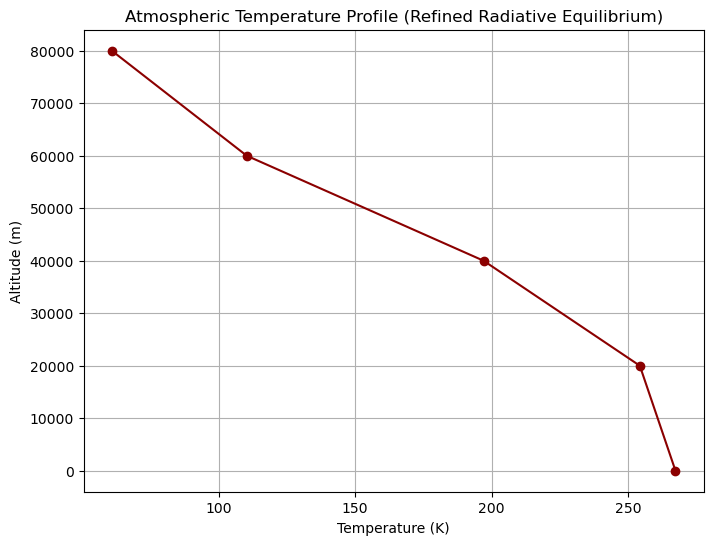

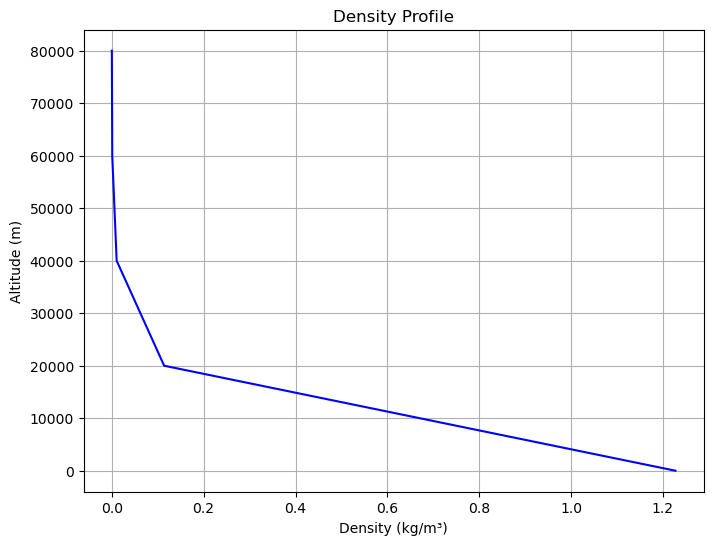

Final temperature (K):
Layer  0 (altitude    0.0 m): T = 267.38 K
Layer  1 (altitude 20000.0 m): T = 254.32 K
Layer  2 (altitude 40000.0 m): T = 197.04 K
Layer  3 (altitude 60000.0 m): T = 110.22 K
Layer  4 (altitude 80000.0 m): T =  60.77 K
Downward flux at top: 240.8
Upward flux from top: 79.84104051772158
Net flux at top: 160.95895948227843


In [341]:
# 0 = surface, N-1 = top atmosphere
N = 5                  
height = 100000.0      
h = height / N        

# Constants
p0 = 101325.0               # pressure (Pa)
T0 = 288.0                  # temperature (K)
g0 = 9.81                   # (m/s^2)
M = 0.029                   # Molar mass air (kg/mol)
R = 8.314                   # (J/(mol·K))
rho0 = p0 / ((R/M) * T0) 
altitude = np.array([i * h for i in range(N)])
print(altitude)
density = rho0 * np.exp(- (g0 * M * altitude) / (R * T0))

############################
sigma_SB = 5.67e-8      
sigma_V = 1e-4        
sigma_IR = 0.005      # (m^2/kg)
F_in_vis = 240.8 

#################################

E = np.zeros(N)  
T_in_V = np.zeros(N)               # visible from above
T_in_IR = np.zeros(N)              # infrared from above
T_out_IR = np.zeros(N)             # infrared from below


T_in_V[N-1] = F_in_vis # what reaches the earth

##############################
def trans_factor(sigma, rho, h):
    return np.exp(-sigma * rho * h)

###############################
tolerance = 1e-3
max_iterations = 5000

for iteration in range(max_iterations):
    E_old = E.copy()
    
    # from top to bottom
    for i in range(N-2, -1, -1):
        T_in_V[i] = T_in_V[i+1] * trans_factor(sigma_V, density[i], h)
    
    # from top to bottom
    T_in_IR[N-1] = 0.0
    for i in range(N-2, -1, -1):
        T_in_IR[i] = (T_in_IR[i+1] + E[i+1]/2.0) * trans_factor(sigma_IR, density[i], h)
    
    # from bottom to top
    T_out_IR[0] = 0.0 
    for i in range(1, N):
        T_out_IR[i] = (T_out_IR[i-1] + E[i-1]/2.0) * trans_factor(sigma_IR, density[i], h)
    
    E_new = np.zeros(N)
    for i in range(N):
        if i == 0:  # Surface 
            ir_contrib = (E[i+1]/2.0 + T_in_IR[i+1]) * (1 - trans_factor(sigma_IR, density[i], h))
            vis_contrib = T_in_V[i+1] * (1 - trans_factor(sigma_V, density[i], h))
            E_new[i] = ir_contrib + vis_contrib
        elif i == N-1:  # Top 
            ir_contrib = (E[i-1]/2.0 + T_out_IR[i-1]) * (1 - trans_factor(sigma_IR, density[i], h))
            vis_contrib = T_in_V[i] * (1 - trans_factor(sigma_V, density[i], h))
            E_new[i] = ir_contrib + vis_contrib
        else:  
            ir_contrib = ((E[i+1] + E[i-1])/2.0 + T_in_IR[i+1] + T_out_IR[i-1]) * (1 - trans_factor(sigma_IR, density[i], h))
            vis_contrib = T_in_V[i+1] * (1 - trans_factor(sigma_V, density[i], h))
            E_new[i] = ir_contrib + vis_contrib
    
    
    if np.max(np.abs(E_new - E_old)) < tolerance:
        print(f"Converged after {iteration + 1} iterations.")
        E = E_new.copy()  
        break
        
    
    E = E_new.copy()



T_layer = (E / sigma_SB) ** 0.25

plt.figure(figsize=(8,6))
plt.plot(T_layer, altitude, '-o', color='darkred')
plt.xlabel("Temperature (K)")
plt.ylabel("Altitude (m)")
plt.title("Atmospheric Temperature Profile (Refined Radiative Equilibrium)")
plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))
plt.plot(density, altitude, '-b')
plt.xlabel("Density (kg/m³)")
plt.ylabel("Altitude (m)")
plt.title("Density Profile")
plt.grid(True)
plt.show()

print("Final temperature (K):")
for i in range(N):
    print(f"Layer {i:2d} (altitude {altitude[i]:6.1f} m): T = {T_layer[i]:6.2f} K")


# Check
F_down_top = T_in_V[N-1]
F_up_top = T_out_IR[N-1] + (E[N-1] / 2.0)
print("Downward flux at top:", F_down_top)
print("Upward flux from top:", F_up_top)
print("Net flux at top:", F_down_top - F_up_top)

